In [ ]:
import xml.etree.ElementTree as etree
from argparse import ArgumentParser
from pathlib import Path
import numpy as np

import h5py
from tqdm import tqdm

import fastmri
from fastmri.data import transforms
from fastmri.data.mri_data import et_query
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

# ADDED (copied from preprocessed_transforms.py)
def downscale_bart_output(img_torch: torch.Tensor, target_size: tuple) -> torch.Tensor:
    """
    Downscale a BART output image (real or complex) from 640x640 to target_size.
    Assumes the input is a 2D complex-valued TENSOR of shape or (H, W, 2) = output of T.to_tensor
    """
    img_torch = img_torch.permute(2, 0, 1).unsqueeze(0)  # -> (1, 2, H, W)

    # Resize to 320x3taget_shape 20 using bilinear interpolation
    img_resized = F.interpolate(img_torch, target_size, mode='bilinear', align_corners=False)
    #img_resized = F.interpolate(img_torch, target_size, mode='area')

     # Convert back to (H, W, 2)
    img_resized = img_resized.squeeze(0).permute(1, 2, 0)  # -> (H, W, 2)

    return img_resized

def save_zero_filled(data_dir, out_dir):
    '''
    Takes CS reconstructions in preprocessed h5 files from data_dir
    - crops to size from encodedSpace?!
    - takes absolute value
    and saves as seperate h5 files with only classical CS reconstruction in out_dir
    '''
    reconstructions = {}

    for fname in list(data_dir.glob("*.npy")):
        print(fname)
        cs_data = np.load(fname)
        ##### ADDED: find matching h5 file
        tgt_file = None
        target_paths = [Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/"),
                            Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_val/")]
        for target_dir in target_paths:
            candidate = target_dir / fname.name.replace("_cs.npy", ".h5")
            if candidate.exists():
                tgt_file = candidate
                break
        assert tgt_file is not None, f"Target file not found for {fname.name}"


        with h5py.File(tgt_file, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])
            #image = transforms.to_tensor(hf["cs_data"][()])
            orig_shape = (hf["kspace"][0].shape[1], hf["kspace"][0].shape[2])
            print(f"Original shape: {orig_shape}")
            print(f"cs_data shape: {cs_data.shape}")
            # initialize zeros to hold images of shape (orig°shape[0], orig_shape[1], 2) for each slice of kspace
            image = torch.zeros((cs_data.shape[0], orig_shape[0], orig_shape[1], 2))
            print(f"Initialized image shape: {image.shape}")

            #### ADDED: reshape cs_data(for every slice)
            for slice in range(cs_data.shape[0]):
                cs_data_slice = transforms.to_tensor(cs_data[slice])
                image[slice]= (downscale_bart_output(cs_data_slice, orig_shape))

            # extract target image width, height from ismrmrd header
            enc = ["encoding", "encodedSpace", "matrixSize"]        ## MISTAKE HERE??: should crop to "reconSpace", not encodedSpace
            crop_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
            )

            # check for FLAIR 203
            if image.shape[-2] < crop_size[1]:
                crop_size = (image.shape[-2], image.shape[-2])

            # crop input image
            image = transforms.complex_center_crop(image, crop_size)

            # absolute value
            image = fastmri.complex_abs(image)

            reconstructions[fname.name] = image # Dictionary mapping input filenames to corresponding reconstructions

            # plot
            # plt.imshow(image[25], cmap='gray')
            # print(f"Image shape after processing: {image.shape}")

        break

data_dir = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_test/"
save_zero_filled(Path(data_dir), None)

/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_test/file1001533_cs.npy
Original shape: (640, 372)
cs_data shape: (35, 640, 640)
Initialized image shape: torch.Size([35, 640, 372, 2])
file1001533_cs.npy
file1001533.h5


Found 380 CS files in output path.
Processing file: file_brain_AXT2_202_2020356.h5
Keys in the file: ['reconstruction']
'ismrmrd_header' not found in the file.
Shape of 'reconstruction': (16, 640, 320)


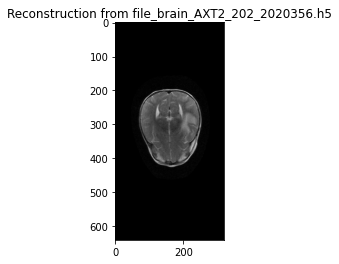

In [13]:
ouput_path = Path("/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Results/CS/")
# Inspect .h5 files in output path
cs_files = list(ouput_path.glob("*.h5"))
print(f"Found {len(cs_files)} CS files in output path.")
for cs_file in cs_files:
    print(f"Processing file: {cs_file.name}")
    with h5py.File(cs_file, "r") as hf:
        # Check keys in the file
        print("Keys in the file:", list(hf.keys()))
        # Check if 'ismrmrd_header' exists
        if 'ismrmrd_header' in hf:
            et_root = etree.fromstring(hf['ismrmrd_header'][()])
            print("ISMRMRD header found.")
            # Extract and print some information from the header
            encoding = et_query(et_root, ["encoding", "encodedSpace", "matrixSize"])
            print(f"Encoded space matrix size: {encoding}")
        else:
            print("'ismrmrd_header' not found in the file.")
 
        # plot "reconstruction" if it exists
        if 'reconstruction' in hf:
            reconstruction = hf['reconstruction'][()]
            print("Shape of 'reconstruction':", reconstruction.shape)
            plt.imshow(np.abs(reconstruction[0]), cmap='gray')
            plt.title(f"Reconstruction from {cs_file.name}")
            plt.show()
        else:
            print("'reconstruction' not found in the file.")

    break  # Remove this break to process all files
